In [1]:
import torch
import torchvision

n_epochs = 20
batch_size_train = 200
batch_size_test = 1000
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#from google.colab import drive
#drive.mount('/content/drive')

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

Extracting /MNIST_dataset/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_dataset/MNIST/raw


Extracting /MNIST_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_dataset/MNIST/raw


Extracting /MNIST_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_dataset/MNIST/raw


Extracting /MNIST_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 32, 32])

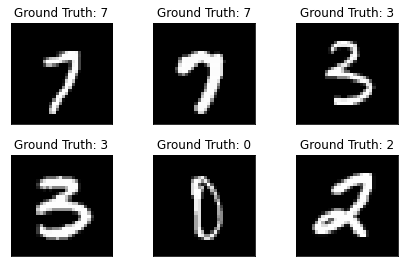

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)            

In [8]:
# Estimate gradient of classification accuracy by Evolutionary Strategies (https://arxiv.org/abs/1703.03864)
# classification accuracy is not differentiable becuase "==" is not differentiable by pytorch

# this version uses a for loop
def ESgrad_(yp, target, sig):
  nSample = 200
  grad = torch.zeros(yp.size()).to(device)
  for i in range(nSample):
    eta = torch.randn(yp.size()).to(device)
    # use mirrorred samples, i.e., both eta and -eta
    new_yp = yp+sig*eta
    pind = new_yp.data.max(1, keepdim=True)[1]
    correct = pind.eq(target.data.view_as(pind)).float()
    grad += correct * eta
    new_yp = yp-sig*eta
    pind = new_yp.data.max(1, keepdim=True)[1]
    correct = pind.eq(target.data.view_as(pind)).float()
    grad += -correct * eta
  return -grad/(2*nSample*sig)  # notice the negative sign, becuase accuracy needs to be maximized, not minimized

# this version is vectorized, does not use any for loop
def ESgrad(yp, target, sig):
  nSample = 200
  eta = torch.randn((yp.size()[0],yp.size()[1],nSample)).to(device)
  eta = torch.cat((eta,-eta),2) # use mirrorred samples, i.e., both eta and -eta
  yp_ = yp.unsqueeze(2)
  target_ = target.unsqueeze(1).unsqueeze(2)
  new_yp = yp_+sig*eta
  pind = new_yp.max(1, keepdim=True)[1]
  correct = ((pind - target_) == 0).float()
  grad = torch.sum(correct * eta, 2)
  return -grad/(2*nSample*sig)  # notice the negative sign, becuase accuracy needs to be maximized, not minimized

In [9]:
import numpy as np
from torch.autograd import Variable

def train(epoch, sig0):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    AccuracyGrad = ESgrad(output,target, sig0*(1.0/(1.+np.log(epoch)))) # approximate gradients by ES
    output.backward(AccuracyGrad) # apply ES esitated grdaients in backprop
    optimizer.step()
    if batch_idx % log_interval == 0:
      pind = output.data.max(1, keepdim=True)[1]
      accuracy = 100.0*pind.eq(target.data.view_as(pind)).sum().float()/len(data)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.2f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), accuracy))
      torch.save(network.state_dict(), 'MNIST_LeNet_ES_model.pth')
      torch.save(optimizer.state_dict(), 'MNIST_LeNet_ES_optimizer.pth')

In [10]:
def validation():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\nValidation set accuracy: {}/{} ({:.2f}%)\n'.format(
    correct, len(validation_loader.dataset),
    100. * correct.float() / len(validation_loader.dataset)))

In [11]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\nTest set accuracy: {}/{} ({:.2f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct.float() / len(test_loader.dataset)))

In [12]:
learning_rate = 0.0005 # use 0.0005 with Adam
sig0 = 1.0
network = Net()
network = network.to(device)
    
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.5, nesterov=True)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

validation()
for epoch in range(1, n_epochs + 1):
  train(epoch, sig0)
  validation()
test()
torch.cuda.empty_cache()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Validation set accuracy: 322/5000 (6.44%)

Train Epoch: 1 [0/55000 (0%)]	Accuracy: 3.00
Train Epoch: 1 [20000/55000 (36%)]	Accuracy: 50.50
Train Epoch: 1 [40000/55000 (73%)]	Accuracy: 52.00

Validation set accuracy: 2939/5000 (58.78%)

Train Epoch: 2 [0/55000 (0%)]	Accuracy: 56.50
Train Epoch: 2 [20000/55000 (36%)]	Accuracy: 72.00
Train Epoch: 2 [40000/55000 (73%)]	Accuracy: 85.00

Validation set accuracy: 4297/5000 (85.94%)

Train Epoch: 3 [0/55000 (0%)]	Accuracy: 89.00
Train Epoch: 3 [20000/55000 (36%)]	Accuracy: 87.00
Train Epoch: 3 [40000/55000 (73%)]	Accuracy: 85.50

Validation set accuracy: 4368/5000 (87.36%)

Train Epoch: 4 [0/55000 (0%)]	Accuracy: 85.00
Train Epoch: 4 [20000/55000 (36%)]	Accuracy: 87.50
Train Epoch: 4 [40000/55000 (73%)]	Accuracy: 89.00

Validation set accuracy: 4384/5000 (87.68%)

Train Epoch: 5 [0/55000 (0%)]	Accuracy: 90.00
Train Epoch: 5 [20000/55000 (36%)]	Accuracy: 90.50
Train Epoch: 5 [40000/55000 (73%)]	Accuracy: 88.00

Validation set accuracy: 4375/50